System ID Nerual Network Assignment

In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os
import control.matlab
from load_data import loadData

np.random.seed(13)

Load the F16 training data

In [ ]:
Cm_t, U_k, Z_k, Cm_v, alpha_v, beta_v = loadData('data/F16traindata_CMabV_2022.csv', 'data/F16validationdata_CMab_2022.csv')

Apply Iterative Extended Kalman Filter to the data

In [ ]:
# from state_estimation.MultiState_IEKF import iterativeEKL
# alpha_t, beta_t, V_t = iterativeEKL(U_k, Z_k, plotting=False)

# np.save('data/alpha_t.npy', alpha_t)
# np.save('data/beta_t.npy', beta_t)
# np.save('data/V_t.npy', V_t)


Ordinary least squares estimator

In [ ]:
from state_estimation.OLS import Ols, OlsSpecialValidation

#Load data
alpha_t = np.load('data/alpha_t.npy')
beta_t = np.load('data/beta_t.npy')
V_t = np.load('data/V_t.npy')

#Define number of states and max order of polynomial
n_states = 3
n_states_sval = 2
m = 9

#Divide data into training and validation sets 80 - 20

n_t = np.size(alpha_t)
n_eval = int(0.8*n_t)
n_sval = np.size(alpha_v)

alpha_t_eval = alpha_t[0:n_eval]
beta_t_eval = beta_t[0:n_eval]
V_t_eval = V_t[0:n_eval]
Cm_t_eval = Cm_t[0:n_eval]

alpha_t_val = alpha_t[n_eval:]
beta_t_val = beta_t[n_eval:]
V_t_val = V_t[n_eval:]
Cm_t_val = Cm_t[n_eval:]

n_val = np.size(alpha_t_val)

#Create empty arrays to store results
theta_val = np.zeros((m*n_states+1,1))
MSE_val = np.zeros(m+1)
theta_sval = np.zeros((m*n_states_sval+1,1))
MSE_sval = np.zeros(m+1)

#Run OLS for different orders of polynomial
for i in range(1,m+1):
    _, MSE_val[i], _, _ = Ols(alpha_t_eval, alpha_t_val, beta_t_eval, beta_t_val, V_t_eval, V_t_val, Cm_t_eval, Cm_t_val, i, n_states)
    _, MSE_sval[i] = OlsSpecialValidation(alpha_v, beta_v, Cm_v, i, n_states_sval)

plt.figure()
plt.plot( np.arange(1,m+1), MSE_val[1:], color = '#00A6D6',label='Mesurments')
plt.plot( np.arange(1, m+1), MSE_sval[1:],'r', label='Special Validation')
plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel('Order of polynomial')
plt.ylabel('MSE')
plt.title('MSE for different orders of polynomial')
plt.savefig('plots/Ols_polynomial.eps', format='eps')
plt.show()

#Best order of polynomial is 2



In [ ]:
#Run OLS for best order of polynomial
C_m, MSE_val, COV, mean_error = Ols(alpha_t, alpha_t, beta_t, beta_t, V_t, V_t, Cm_t, Cm_t, 4, n_states)
C_m_sval, MSE_sval = OlsSpecialValidation(alpha_v, beta_v, Cm_v, 4, n_states_sval)


def array_to_latex(arr):
    res = '\\begin{bmatrix}'
    for row in arr:
        res += ' & '.join([str(e) for e in row]) + '\\\\'
    res += '\\end{bmatrix}'
    return res

COV= np.around(COV,4)
#print( array_to_latex(COV))
#TODO: Put measuements (alpha and beta) into validation set polynomial and compare output to output of not special validation polynomial, same input diffrent output
#Root mean square error of special validation set
C_m_special, _ = OlsSpecialValidation(alpha_t, beta_t, Cm_t, 4, n_states_sval)
rms = np.sqrt(np.mean((C_m_special - Cm_t)**2))

Radial Base Function Nerural Network

In [ ]:
from rbf_neural_net.rbf import RbfNet

inputs_train = np.array([alpha_t_eval, beta_t_eval, V_t_eval]).reshape(3,8000)
outputs_train = Cm_t_eval.T

inputs_val = np.array([alpha_t_val, beta_t_val, V_t_val]).reshape(3,2001)
outputs_val = Cm_t_val.T
#Train RBF network with Linear Regression
n_hidden = 10
trials = 10
mse_rbf_lr_val = np.zeros(trials)
for i in range(trials):
    RbfLR = RbfNet(3,n_hidden,1)
    LW = RbfLR.trainLR(inputs_train,outputs_train)

    C_m_rbf_lr,mse_rbf_lr= RbfLR.evaluate(inputs_train, outputs_train)
    C_m_rbf_lr_val,mse_rbf_lr_val[i] = RbfLR.evaluate(inputs_val, outputs_val)




In [ ]:
from rbf_neural_net.rbf_lm import RbfLMnet

#Train RBF network with Levenberg-Marquardt
n_hidden = 10
mse_rbf_lm_val = np.zeros(trials)
for i in range(trials):
    print(i)
    RbfLM = RbfLMnet(3,n_hidden,1)
    mu_list,_ = RbfLM.trainLM(inputs_train,outputs_train, 600,  1e-6,  2, adaptive=True, center_init='kmeans')

    C_m_rbf_lm, _ = RbfLM.evaluate(inputs_train, outputs_train)
    C_m_rbf_lm_val, mse_rbf_lm_val[i] = RbfLM.evaluate(inputs_val, outputs_val)

plt.figure()
plt.plot(mu_list, color = '#00A6D6')
plt.grid()
plt.xlabel('Epoch[-]')
plt.ylabel('Damping Ratio[-]')




In [ ]:
plt.figure()
plt.boxplot([mse_rbf_lr_val, mse_rbf_lm_val], labels=['Linear Regression', 'Levenberg-Marquardt'])
plt.ylabel('MSE[-]')
plt.title('MSE for different training algorithms')
plt.grid()
plt.savefig('plots/MSE_training_algorithms.eps', format='eps')

In [ ]:
# sensitivity analysis to initial mu value
mu_list = np.linspace(0.5,100,20)
trials = 20
mse_rbf_lm_val_mu = np.zeros(len(mu_list))
for j in range(len(mu_list)):
    print(j)
    for i in range(trials):
        RbfLM = RbfLMnet(3,n_hidden,1)
        _ , _= RbfLM.trainLM(inputs_train,outputs_train, 600,  1e-6,  mu_list[j], adaptive=False, center_init='kmeans')

        C_m_rbf_lm, mse_rbf_lm= RbfLM.evaluate(inputs_train, outputs_train)
        C_m_rbf_lm_val_mu, temp = RbfLM.evaluate(inputs_val, outputs_val)
        mse_rbf_lm_val_mu[j] += temp 
    mse_rbf_lm_val_mu[j] /= trials

mse_rbf_lm_val_mu_adaptive = np.zeros(len(mu_list))
for j in range(len(mu_list)):
    print(j)
    for i in range(trials):
        RbfLM = RbfLMnet(3,n_hidden,1)
        _, _ = RbfLM.trainLM(inputs_train,outputs_train, 600,  1e-6,  mu_list[j], adaptive=True, center_init='kmeans')

        _, mse_net_lm= RbfLM.evaluate(inputs_train, outputs_train)
        C_m_rbf_lm_val_mu, temp = RbfLM.evaluate(inputs_val, outputs_val)
        mse_rbf_lm_val_mu_adaptive[j] += temp 
    mse_rbf_lm_val_mu_adaptive[j] /= trials




In [ ]:

plt.figure()
plt.plot(mu_list, mse_rbf_lm_val_mu, color = 'r', label= 'Non-adaptive')
plt.plot(mu_list, mse_rbf_lm_val_mu_adaptive,  color = '#00A6D6',label= 'Adaptive')
plt.grid()
plt.xlabel('Initial Damping Ratio[-]')
plt.ylabel('MSE[-]')
plt.title('MSE for different initial damping ratios')
plt.yscale('log')
plt.legend()
plt.savefig('plots/MSE_initial_damping_ratio.eps', format='eps')


Optimizing number of neurons

In [ ]:
#Optimize number of neurons for RBF network with Levenberg-Marquardt
max_neurons = 60
rate = 2
mse_rbf_neuron =  np.array([])
mse_rbf_neuron_val = np.array([])
neurons = np.arange(rate,max_neurons,rate)
for n in neurons:
    print(n)
    RbfLM = RbfLMnet(3,n,1)
    _,_ = RbfLM.trainLM(inputs_train,outputs_train, 800,  1e-10,  2, adaptive=True, center_init='kmeans')
    _, temp0, = RbfLM.evaluate(inputs_train, outputs_train)
    _, temp1 = RbfLM.evaluate(inputs_val, outputs_val)
    mse_rbf_neuron = np.append(mse_rbf_neuron, temp0)
    mse_rbf_neuron_val = np.append(mse_rbf_neuron_val, temp1)


In [ ]:
#Plot MSE for different number of neurons
plt.figure()
plt.plot(neurons, mse_rbf_neuron,'g' ,label='Training')
plt.plot(neurons, mse_rbf_neuron_val, 'r', label='Validation')
plt.plot(neurons, mse_rbf_neuron+mse_rbf_neuron_val, color = '#00A6D6', label='Total')
plt.title('MSE for different number of neurons')
plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel('Number of neurons[-]')
plt.ylabel('MSE[-]')
plt.savefig('plots/MSE_neurons.eps', format='eps')

# Get index of minimum MSE for all data
min_index = np.argmin(mse_rbf_neuron+mse_rbf_neuron_val)
print('Minimum MSE for all data is achieved with', neurons[min_index], 'neurons')
print('MSE for all data is', mse_rbf_neuron[min_index]+mse_rbf_neuron_val[min_index])

Feed Forward Neural Network

In [ ]:
from feed_forward_net.feedforward import FFNet
from sklearn import preprocessing

#Normalize data input and output
input_train_norm = preprocessing.normalize(inputs_train)
output_train_norm = outputs_train/ np.linalg.norm(outputs_train)

#Normalize Validation data
input_val_norm = preprocessing.normalize(inputs_val)
output_val_norm = outputs_val/ np.linalg.norm(outputs_val)
n_hidden = 20


In [ ]:

FFNetBP = FFNet(3,n_hidden,1)
_ = FFNetBP.trainBackProp(input_train_norm,output_train_norm, 10000, 1e-2, adaptive = True )

C_m_ff_bp, mse_ff_bp= FFNetBP.evaluate(input_train_norm, output_train_norm)
C_m_ff_val_bp, mse_ff_val_bp = FFNetBP.evaluate(input_val_norm, output_val_norm)
print('MSE for FF network with backpropagation is', mse_ff_bp)
print('MSE for FF network with backpropagation on validation data is', mse_ff_val_bp)

In [ ]:
#Run FF netwrok with diffrenet initial damping ratios
mu_list = np.linspace(1e-10,1e-2,20)
trials = 20

mse_ff_bp_val_mu_adaptive = np.zeros(len(mu_list))
for j in range(len(mu_list)):
    print(j)
    for i in range(trials):
        FFNet_mu = FFNet(3,n_hidden,1)
        _ = FFNet_mu.trainBackProp(input_train_norm,output_train_norm, 5000, mu_list[j], adaptive = True)

        _, temp = FFNet_mu.evaluate(input_val_norm, output_val_norm)
        mse_ff_bp_val_mu_adaptive[j] += temp 
    mse_ff_bp_val_mu_adaptive[j] /= trials

In [ ]:
#Plot MSE for different initial damping ratios
plt.figure()
plt.plot(mu_list, mse_ff_bp_val_mu_adaptive, color = '#00A6D6')
plt.grid()
plt.xlabel('Initial Damping Ratio[-]')
plt.ylabel('MSE[-]')
plt.title('MSE for different initial damping ratios')
plt.yscale('log')
plt.xscale('log')
plt.savefig('plots/MSE_initial_damping_ratio_FF.eps', format='eps')

In [59]:
from feed_forward_net.feedforward import FFNet
#Train Network with Levenberg-Marquardt
n_hidden = 5
FFNetLM = FFNet(3,n_hidden,1)
_ = FFNetLM.trainLM(input_train_norm, output_train_norm, 8000,  5e-3, adaptive=True)

C_m_ff_lm, mse_ff_lm= FFNetLM.evaluate(input_train_norm, output_train_norm)
C_m_ff_val_lm, mse_ff_val_lm = FFNetLM.evaluate(input_val_norm, output_val_norm)
print('MSE for FF network with Levenberg-Marquardt is', mse_ff_lm)
print('MSE for FF network with Levenberg-Marquardt on validation data is', mse_ff_val_lm)

/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MSE for FF network with Levenberg-Marquardt is 5.224793143832756e-07
MSE for FF network with Levenberg-Marquardt on validation data is 0.266763462145247


In [ ]:
#Run FF netwrok with diffrenet initial damping ratios
mu_list = np.linspace(1e-10,1e-2,20)
trials = 20

mse_ff_lm_val_mu_adaptive = np.zeros(len(mu_list))
for j in range(len(mu_list)):
    print(j)
    for i in range(trials):
        FFNet_mu = FFNet(3,n_hidden,1)
        _ = FFNet_mu.trainLM(input_train_norm,output_train_norm, 8000, mu_list[j], adaptive = True)

        _, temp = FFNet_mu.evaluate(input_val_norm, output_val_norm)
        mse_ff_lm_val_mu_adaptive[j] += temp 
    mse_ff_lm_val_mu_adaptive[j] /= trials

In [ ]:
#Plot MSE for different initial damping ratios
plt.figure()
plt.plot(mu_list, mse_ff_lm_val_mu_adaptive, color = '#00A6D6')
plt.grid()
plt.xlabel('Initial Damping Ratio[-]')
plt.ylabel('MSE[-]')
plt.title('MSE for different initial damping ratios')
plt.yscale('log')
plt.xscale('log')
plt.savefig('plots/MSE_initial_damping_ratio_FF_LM.eps', format='eps')

In [ ]:
#Optimize number of neurons for FF network with Levenberg-Marquardt and backpropagation
max_neurons = 60
rate = 2
mse_ff_neuron_bp =  np.array([])
mse_ff_neuron_bp_val = np.array([])
mse_ff_neuron_lm = np.array([])
mse_ff_neruon_lm_val = np.array([])
neurons = np.arange(rate,max_neurons,rate)
for n in neurons:
    print(n)
    FFNetBP = FFNet(3,n,1)
    _ = FFNetBP.trainBackProp(input_train_norm,output_train_norm, 5000, 1e-2, adaptive = True)
    _, temp0 = FFNetBP.evaluate(input_train_norm, output_train_norm)
    _, temp1 = FFNetBP.evaluate(input_val_norm, output_val_norm)
    mse_ff_neuron_bp = np.append(mse_ff_neuron_bp, temp0)
    mse_ff_neuron_bp_val = np.append(mse_ff_neuron_bp_val, temp1)

    FFNetLM = FFNet(3,n,1)
    _ = FFNetLM.trainLM(input_train_norm, output_train_norm, 5000,  1e-3, adaptive=True)
    _, temp0 = FFNetLM.evaluate(input_train_norm, output_train_norm)
    _, temp1 = FFNetLM.evaluate(input_val_norm, output_val_norm)
    mse_ff_neuron_lm = np.append(mse_ff_neuron_lm, temp0)
    mse_ff_neruon_lm_val = np.append(mse_ff_neruon_lm_val, temp1)
       


In [ ]:
#Plot MSE for different number of neurons for FF network with Levenberg-Marquardt and backpropagation in 2 figures
plt.figure()
plt.plot(neurons[:10], mse_ff_neuron_bp[:10], 'g', label='Training')
plt.plot(neurons[:10], mse_ff_neuron_bp_val[:10], 'r', label='Validation')
plt.plot(neurons[:10], (mse_ff_neuron_bp+mse_ff_neuron_bp_val)[:10],  color = '#00A6D6', label='Total')
plt.grid()
plt.legend()
plt.xlabel('Number of neurons[-]')
plt.ylabel('MSE[-]')
plt.title('MSE for FF network with backpropagation')
plt.yscale('log')
plt.savefig('plots/MSE_neurons_FF_BP.eps', format='eps')

plt.figure()
plt.plot(neurons, mse_ff_neuron_lm, 'g', label='Training')
plt.plot(neurons, mse_ff_neruon_lm_val, 'r', label='Validation')
plt.plot(neurons, mse_ff_neuron_lm+mse_ff_neruon_lm_val,  color = '#00A6D6', label='Total')
plt.grid()
plt.legend()
plt.xlabel('Number of neurons[-]')
plt.ylabel('MSE[-]')
plt.title('MSE for FF network with Levenberg-Marquardt')
plt.yscale('log')
plt.savefig('plots/MSE_neurons_FF_LM.eps', format='eps')
plt.show()

In [60]:
#Plot MSE for both FF networks over 50 trials
trials = 50
mse_ff_bp_val_mu = np.zeros(trials)
mse_ff_lm_val_mu = np.zeros(trials)
n_hidden = 20
for i in range(trials):
    FFNetBP = FFNet(3,n_hidden,1)
    _ = FFNetBP.trainBackProp(input_train_norm,output_train_norm, 5000, 1e-2, adaptive = True)
    _, mse_ff_bp_val_mu[i] = FFNetBP.evaluate(input_val_norm, output_val_norm)

    FFNetLM = FFNet(3,n_hidden,1)
    _ = FFNetLM.trainLM(input_train_norm, output_train_norm, 5000,  1e-2, adaptive=True)
    _, mse_ff_lm_val_mu[i] = FFNetLM.evaluate(input_val_norm, output_val_norm)




/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

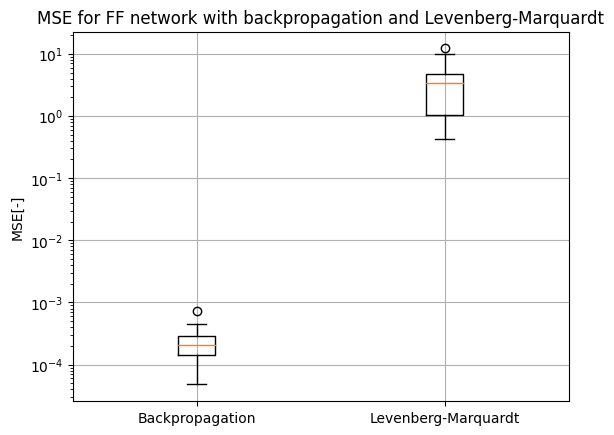

In [61]:
plt.figure()
plt.boxplot([mse_ff_bp_val_mu, mse_ff_lm_val_mu], labels=['Backpropagation', 'Levenberg-Marquardt'])
plt.grid()
plt.ylabel('MSE[-]')
plt.title('MSE for FF network with backpropagation and Levenberg-Marquardt')
plt.yscale('log')
plt.savefig('plots/MSE_FF.eps', format='eps')

In [ ]:
#Plot the mse values over every epoch for the FF network with Levenberg-Marquardt and backpropagation
n_hidden = 10
FFNetBP = FFNet(3,n_hidden,1)
mse_ff_bp_list = FFNetBP.trainBackProp(input_train_norm,output_train_norm, 2000, 1e-2, adaptive = True)
FFNetLM = FFNet(3,n_hidden,1)
mse_ff_lm_list = FFNetLM.trainLM(input_train_norm, output_train_norm, 2000,  1e-3, adaptive=True)


In [ ]:

plt.figure()
plt.plot(mse_ff_bp_list[:250], color = '#00A6D6', label='Backpropagation')
plt.plot(mse_ff_lm_list[:250], 'r', label='Levenberg-Marquardt')
plt.grid()
plt.legend()
plt.xlabel('Epoch[-]')
plt.ylabel('MSE[-]')
plt.title('MSE for FF network with backpropagation and Levenberg-Marquardt')
plt.yscale('log')
plt.savefig('plots/MSE_FF_epochs.eps', format='eps')


/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


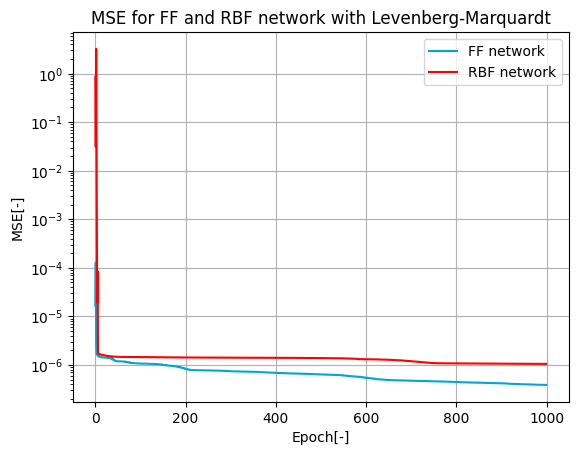

In [52]:
from rbf_neural_net.rbf_lm import RbfLMnet
#Plot the mse values over every epoch for FF and RBF network with LM
n_hidden = 10
FFNetBP = FFNet(3,n_hidden,1)
mse_ff_bp_list = FFNetBP.trainLM(input_train_norm,output_train_norm, 1000, 1e-3, adaptive = True)

RbfLM = RbfLMnet(3,n_hidden,1)
_,mse_rbf_lm_list = RbfLM.trainLM(input_train_norm, output_train_norm, 1000,  1e-7, 1e-3,adaptive=True)

plt.figure()
plt.plot(mse_ff_bp_list, color = '#00A6D6', label='FF network') 
plt.plot(mse_rbf_lm_list, color = 'r', label='RBF network')
plt.grid()
plt.legend()
plt.xlabel('Epoch[-]')
plt.ylabel('MSE[-]')
plt.title('MSE for FF and RBF network with Levenberg-Marquardt')
plt.yscale('log')
plt.savefig('plots/MSE_FF_RBF_epochs.eps', format='eps')



In [50]:
#Plot MSE for FF and RBF network with Levenberg-Marquardt over 10 trials
trials = 50
mse_ff_lm_val_mu = np.zeros(trials)
mse_rbf_lm_val_mu = np.zeros(trials)
n_hidden = 10
for i in range(trials):
    FFNetLM = FFNet(3,n_hidden,1)
    _  = FFNetLM.trainLM(input_train_norm, output_train_norm, 1000,  1e-3, adaptive=True)
    _, mse_ff_lm_val_mu[i] = FFNetLM.evaluate(input_val_norm, output_val_norm)

    RbfLM = RbfLMnet(3,n_hidden,1)
    _, _ = RbfLM.trainLM(input_train_norm, output_train_norm, 1000,  1e-7, 1e-3, adaptive=True)
    _, mse_rbf_lm_val_mu[i] = RbfLM.evaluate(input_val_norm, output_val_norm)

plt.figure()
plt.boxplot([mse_ff_lm_val_mu, mse_rbf_lm_val_mu], labels=['FF network', 'RBF network'])
plt.grid()
plt.ylabel('MSE[-]')
plt.title('MSE for FF and RBF network with Levenberg-Marquardt')
plt.yscale('log')
plt.savefig('plots/MSE_FF_RBF.eps', format='eps')

/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Gradient is small enough


/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Mu too high


/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Federico/opt/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

LinAlgError: SVD did not converge